In [1]:
import glob
import importlib
import sys, os

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
from itertools import cycle

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import F19

import measure_extinction
from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

from measure_extinction.plotting.plot_spec import plot_multi_spectra, plot_spectrum
from measure_extinction.merge_obsspec import _wavegrid

file_path = "/Users/pyanchulova/Documents/extstar_data/"
savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
folder = ""

if not os.path.isdir(savefile_path + folder):
    print("making new dir", (savefile_path + folder))
    os.system("mkdir " + savefile_path + folder)

m31_list = [
"m31_e2_j004413.84+414903.9"]
m31_list = [
"m31_e1_j004354.05+412626.0","m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4","m31_e6_j004438.71+415553.5",
"m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
# "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
"m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
"m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
]
starname = m31_list[0]
fstarname = f"{starname}.dat"
velocity = -109.3 # M31 radial velocity from NED
relband = "ACS_F475W"
relband_str = "$F475W$"
starstr = starname.split("m31_")[1].split("_")[0]
print(starname, starstr)
fontsize=14

def get_red_star(fstarname, file_path, excl_zero=True, rebin=True, rbres=750):
    """
    Sample call: red_star, band_names, data_names = get_red_star(fstarname, file_path)
    """
    # get the observed reddened star data
    reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    
    # Turn zeros into NaNs
    if excl_zero:
        for curtype in reddened_star.data.keys():
            reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
    
    # Implement rebinning here eventually
#     if rebin:
#         print("Rebinning spectra to {} res".format(rbres))
#         gres = 750
#         rwaverange = [0.11, 0.32] * u.micron
#         reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

    band_names = reddened_star.data["BAND"].get_band_names()
    data_names = reddened_star.data.keys()

    return reddened_star, band_names, data_names

m31_e1_j004354.05+412626.0 e1


In [28]:
m31_list = [
"m31_e1_j004354.05+412626.0","m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4","m31_e6_j004438.71+415553.5",
"m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
# "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
"m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
"m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
]

Specify the location of the model and observed data

In [2]:
# file_path = "/Users/pyanchulova/Documents/extstar_data/"
# savefile_path = "/Users/pyanchulova/Documents/ext-science/figs/"
# folder = ""

# if not os.path.isdir(savefile_path + folder):
#     print("making new dir", (savefile_path + folder))
#     os.system("mkdir " + savefile_path + folder)

# Karl-level STIS data location
#karl_data_path = "~/../../user/kgordon/Python_git/extstar_data/STIS_Data/"

Define star specific parameters

In [3]:
# m31_list = [
# "m31_e2_j004413.84+414903.9"]
# starname = m31_list[0]
# fstarname = f"{starname}.dat"
# velocity = -109.3 # M31 radial velocity from NED
# relband = "ACS_F475W"
# relband_str = "$F475W$"
# starstr = starname.split("m31_")[1].split("_")[0]
# print(starname, starstr)
# fontsize=14

m31_e2_j004413.84+414903.9 e2


### Read in the star data

In [2]:
# def get_red_star(fstarname, file_path, excl_zero=True, rebin=True, rbres=750):
#     """
#     Sample call: red_star, band_names, data_names = get_red_star(fstarname, file_path)
#     """
#     # get the observed reddened star data
#     reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
    
#     # Turn zeros into NaNs
#     if excl_zero:
#         for curtype in reddened_star.data.keys():
#             reddened_star.data[curtype].fluxes[reddened_star.data[curtype].npts == 0] = np.nan
    
#     # Implement rebinning here eventually
# #     if rebin:
# #         print("Rebinning spectra to {} res".format(rbres))
# #         gres = 750
# #         rwaverange = [0.11, 0.32] * u.micron
# #         reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

#     band_names = reddened_star.data["BAND"].get_band_names()
#     data_names = reddened_star.data.keys()

#     return reddened_star, band_names, data_names

### Read in models (choose rebinned or not)

In [2]:
rebin=True
rwaverange=None
gres=None
if rebin:
    rwaverange = [0.1, 0.32] * u.micron
    gres = 150

tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# run line just to get band names and spectra needed for ModelData
red_star, band_names, data_names = get_red_star(fstarname, file_path)


print("Get Model Data")
modinfo_rb = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
    rebin=rebin,
    waverange=rwaverange,
    resolution=gres
)

Get Model Data


In [3]:
print("check fluxes", len(modinfo_rb.fluxes["STIS"][0]))
print("len waves STIS", len(modinfo_rb.waves["STIS"]))
print("waves.value", modinfo_rb.waves["STIS"].to(u.micron).value)
print("fluxes", modinfo_rb.fluxes["STIS"][1])

check fluxes 105
len waves STIS 105
waves.value [0.11055687 0.11167624 0.11280695 0.11394911 0.11510283 0.11626823
 0.11744544 0.11863456 0.11983572 0.12104904 0.12227465 0.12351266
 0.12476321 0.12602643 0.12730243 0.12859135 0.12989332 0.13120848
 0.13253695 0.13387887 0.13523438 0.13660361 0.1379867  0.1393838
 0.14079505 0.14222058 0.14366055 0.14511509 0.14658437 0.14806852
 0.14956769 0.15108205 0.15261174 0.15415691 0.15571773 0.15729436
 0.15888694 0.16049565 0.16212065 0.16376211 0.16542018 0.16709504
 0.16878685 0.1704958  0.17222205 0.17396578 0.17572716 0.17750638
 0.17930361 0.18111904 0.18295285 0.18480522 0.18667635 0.18856643
 0.19047564 0.19240418 0.19435225 0.19632005 0.19830776 0.20031561
 0.20234378 0.20439249 0.20646194 0.20855234 0.21066391 0.21279685
 0.2149514  0.21712775 0.21932615 0.2215468  0.22378993 0.22605578
 0.22834457 0.23065653 0.2329919  0.23535091 0.23773381 0.24014084
 0.24257224 0.24502825 0.24750914 0.25001514 0.25254651 0.25510351
 0.25768641 0.2

### Test plot model rebin (optional)

Text(0.5, 0, '$\\lambda [\\mu m]$')

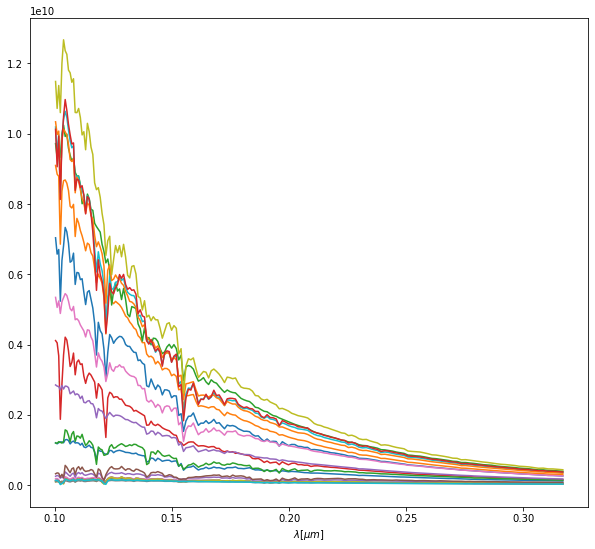

In [4]:
# Test plotting intrinsic model SED
fig, ax = plt.subplots(figsize=(10, 9))

#Try 10 model fluxes
for i in range(20):
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][i], 
        )
ax.set_xlabel("$\lambda [\mu m]$")

### Limit list to two entries

In [22]:
m31_list=m31_list[0:2]
print (m31_list)

['m31_e1_j004354.05+412626.0', 'm31_e2_j004413.84+414903.9']


### Test exclusion of zero-flux data (optional)

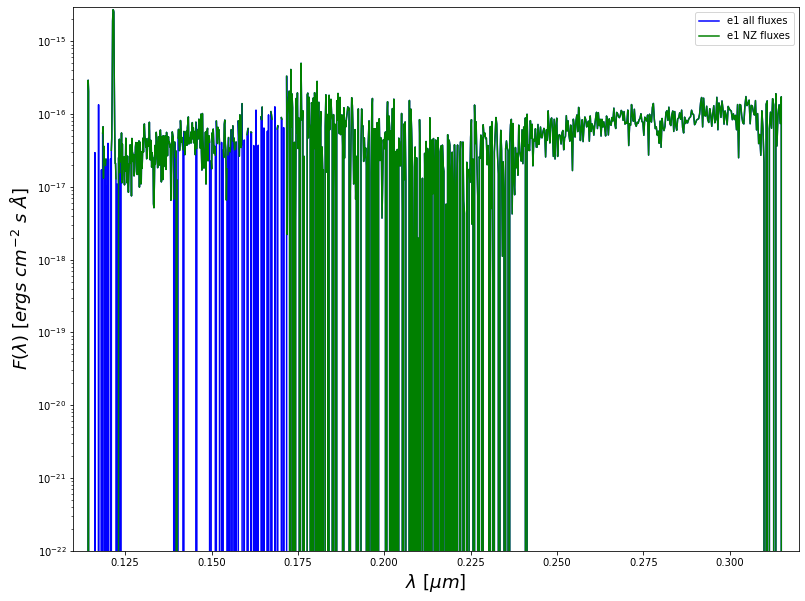

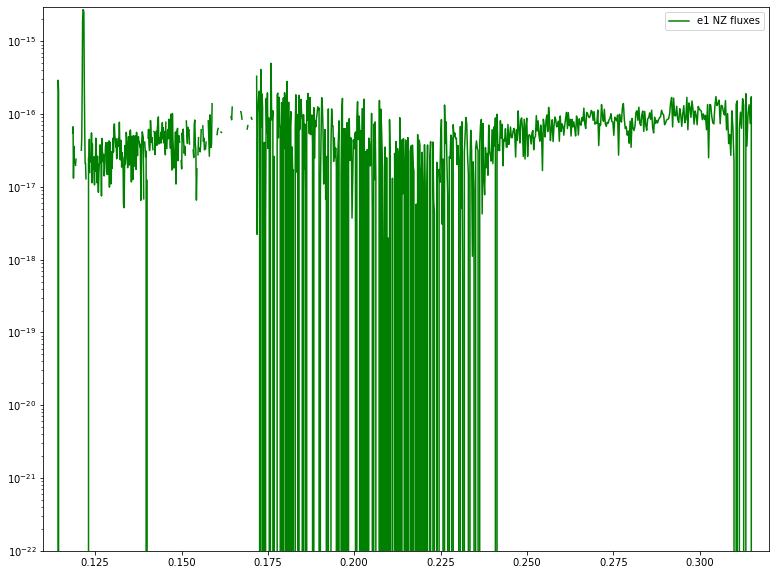

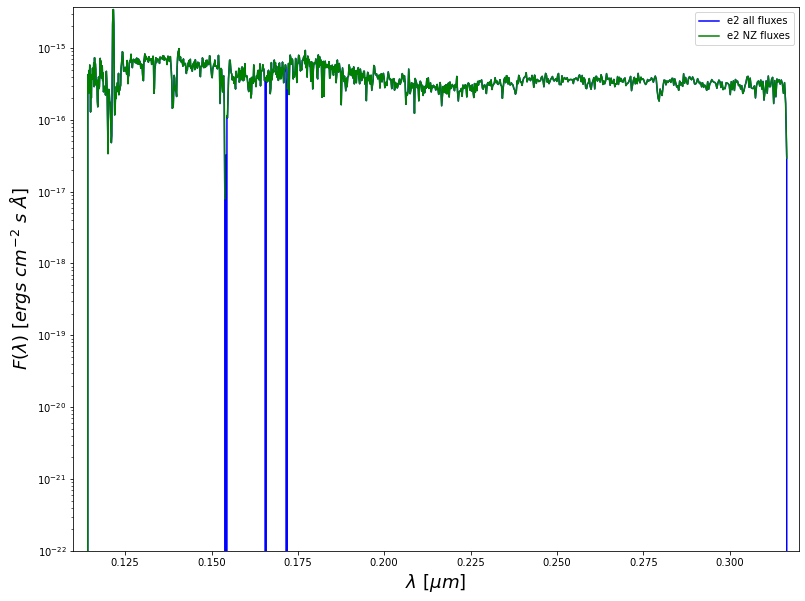

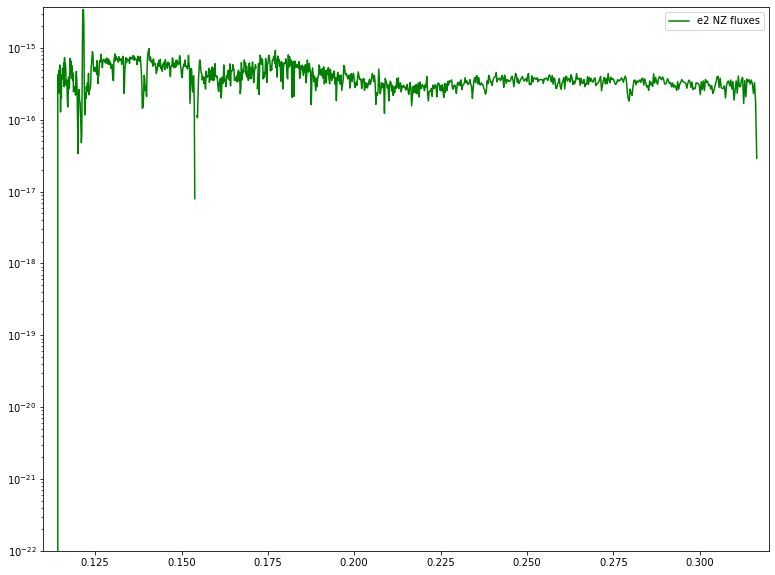

In [24]:
for i in range(len(m31_list)):
    starname = m31_list[i]
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split("m31_")[1].split("_")[0]

    # Get star data, WITHOUT excluding zero flux
    red_star_a, band_names_a, data_names_a = get_red_star(fstarname, file_path, excl_zero=False)
    norm_data_a = np.average(red_star_a.data["BAND"].fluxes)

    # Get star data, with only non-zero flux
    red_star_nz, band_names_nz, data_names_nz = get_red_star(fstarname, file_path, excl_zero=True)
    norm_data_nz = np.average(red_star_nz.data["BAND"].fluxes)

    norm_flux_a = red_star_a.data["STIS"].fluxes / norm_data_a
    norm_flux_nz = red_star_nz.data["STIS"].fluxes / norm_data_nz

    # Plot spectra, both with and w/o zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "b-", label=starstr + " all fluxes")
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "g-", label=starstr + " NZ fluxes")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    ax.set_ylim(1e-22, ylim[1])
    ax.set_yscale("log")
    plt.legend()
    plt.savefig(savefile_path + "non_zero_flux_spectra/" + starstr + "both_yaxis_t3.pdf")

    # Plot only non-zero fluxes
    fig, ax = plt.subplots(figsize=(13, 10))
    # ax.plot(red_star_a.data["STIS"].waves, red_star_a.data["STIS"].fluxes, "b-")
    ax.plot(red_star_nz.data["STIS"].waves, red_star_nz.data["STIS"].fluxes, "g-", label=starstr + " NZ fluxes")
    ax.set_xlim(0.11,0.32)
    ylim = ax.get_ylim()
    ax.set_ylim(1e-22, ylim[1])
    ax.set_yscale("log")
    plt.legend()
    plt.savefig(savefile_path + "non_zero_flux_spectra/" + starstr + "nz_yaxis_t3.pdf")

In [8]:
rwaverange = [0.1, 0.32] * u.micron
gres = 150
rebin=True
# gres = 750
# rwaverange = [0.11, 0.32] * u.micron
# rebin_params not used
# rebin_params = [[rwaverange], gres]
# print(type(rwaverange), type(gres))
# print(type(rebin_params))

### Plot rebinned spectra (measure_extinction; optional)

m31_list ['m31_e7_j004454.37+412823.9']
m31_e7_j004454.37+412823.9
starstr e7
plotting ls = s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


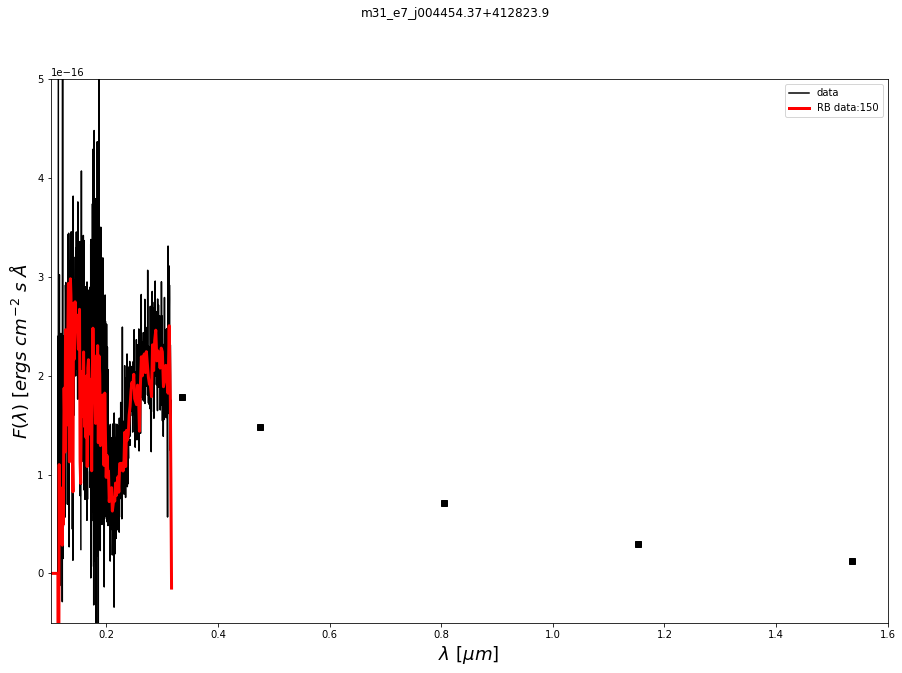

In [59]:
# Rebin params
# Tested resolutions: 125, 250, 500, 750; Data ~= 1000; > Data: 1250, 1500, 2000
# gres = 750
# rwaverange = [0.11, 0.32] * u.micron
rwaverange = [0.1, 0.32] * u.micron
gres = 150
plot_zoomed = False
plot_norm = False

m31_list = [
"m31_e1_j004354.05+412626.0","m31_e2_j004413.84+414903.9","m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0","m31_e5_j004431.66+413612.4","m31_e6_j004438.71+415553.5",
"m31_e7_j004454.37+412823.9","m31_e8_j004511.82+415025.3","m31_e9_j004511.85+413712.9", 
# "m31_e10_j004512.73+413726.4", # No STIS data, "m31_e11_j004535.40+414431.5", # No STIS data
"m31_e12_j004539.00+415439.0","m31_e13_j004539.70+415054.8",
"m31_e14_j004543.46+414513.6","m31_e15_j004546.81+415431.7",
]
m31_list = [m31_list[6]] # e7
print("m31_list", m31_list)

for i in range(len(m31_list)):
    starname = m31_list[i]
    print(starname)
    fstarname = f"{starname}.dat"
    path = f"{file_path}/DAT_files/"
    starstr = starname.split("m31_")[1].split("_")[0]
    print("starstr", starstr)

    # default settings
    #plot_spectrum(starname, path)

    # Get star data; default removes zero-flux data
    red_star, band_names, data_names = get_red_star(fstarname, file_path)
    norm_data = np.average(red_star.data["BAND"].fluxes)

    # ================== UV spectra WL range only ==============
    if plot_zoomed:
        fig, (ax,ax2) = plt.subplots(2, 1, figsize=(11, 12))
    else:
        plt.figure(figsize=(15, 10))
        ax = plt.gca()
        
    # plot the bands and all spectra for this star
    for cspec in data_names:
        ptype = "-"
        label="data"
        
        if cspec == "BAND":
            print("plotting ls = s")
            ptype = "s"
            label=""

        norm_flux = red_star.data[cspec].fluxes / norm_data
        if plot_norm:
            not_rb_data = norm_flux
        else:
            not_rb_data = red_star.data[cspec].fluxes
            
        # Plot default observations
        ax.plot(
            red_star.data[cspec].waves,
            not_rb_data,
            "k" + ptype,
            label=label,
        )

        # Rebin an instance of the STIS spectra; does not rebin the original instance
        if cspec == "STIS":
            spec_rb = red_star.data[cspec]
            spec_rb.rebin_constres(rwaverange, gres)

            if plot_norm:
                rb_data = spec_rb.fluxes
            else:
                rb_data = spec_rb.fluxes

            # Plot rebinned spectra
            ax.plot(
                spec_rb.waves,
                rb_data,
                "r" + ptype,
                label="RB data:{}".format(gres) ,
                lw=3
            )
    #     ax.set_ylim(-0.1e-15, 0.7e-15)
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$", fontsize=1.3 * fontsize)
        ax.set_ylim(-0.05e-15, 0.5e-15)
#         if starstr == 'e9':
#             ax2.set_ylim(0, 15)
#         ax.set_xlim(0.1,0.325)
        ax.set_xlim(0.1,1.6)
        ax.legend()

    # ============ Zoomed plot ==================
    if plot_zoomed:
        red_star, band_names, data_names = get_red_star(fstarname, file_path)

        for cspec in data_names:

            # zoomed plot
            norm_flux = red_star.data[cspec].fluxes / norm_data
            ax2.plot(
                red_star.data[cspec].waves,
                red_star.data[cspec].fluxes,#norm_flux,
                "k" + ptype,
            )
            if cspec == "STIS":
                ax2.plot(
                    spec_rb.waves,
                    spec_rb.fluxes,# / norm_data,
                    "r" + ptype,
                    lw=2
            )
    #         ax2.set_ylim(-10, 10)
    #         if starstr == 'e9':
    #             ax2.set_ylim(0, 15)
            ax2.set_xlim(0.125,0.2)

    plt.suptitle(starname)
    plt.savefig(savefile_path + "spectra/" + starstr + "_spec_phot_" + str(gres) + "res.pdf")

    # figs with NaN have zero fluxes turned to NaNs to exclude from plotting or calcs
#     plt.savefig(savefile_path + "rebinned/t5_not_norm_" + starstr + "_" + str(gres) + "res.png")
#     plt.savefig(savefile_path + "rebinned/_" + starstr + "_" + str(gres) + "res.pdf")

### Plot offset spectra

type m31_list <class 'list'>
type m31_list_arr <class 'numpy.ndarray'>
m31_list_arr ['m31_e2_j004413.84+414903.9' 'm31_e3_j004420.52+411751.1'
 'm31_e4_j004427.47+415150.0' 'm31_e5_j004431.66+413612.4'
 'm31_e6_j004438.71+415553.5' 'm31_e7_j004454.37+412823.9'
 'm31_e8_j004511.82+415025.3' 'm31_e9_j004511.85+413712.9'
 'm31_e12_j004539.00+415439.0' 'm31_e13_j004539.70+415054.8'
 'm31_e15_j004546.81+415431.7']
slopes [<Quantity 1.90416546>, <Quantity 1.36435562>, <Quantity 0.83203105>, <Quantity 0.49883329>, <Quantity 1.03014896>, <Quantity 1.1253745>, <Quantity 0.59459292>, <Quantity 2.50878025>, <Quantity 1.05191509>, <Quantity 0.63295277>, <Quantity 0.88145461>]
m31_e5_j004431.66+413612.4
m31_e8_j004511.82+415025.3
m31_e13_j004539.70+415054.8
m31_e4_j004427.47+415150.0
m31_e15_j004546.81+415431.7
m31_e6_j004438.71+415553.5
m31_e12_j004539.00+415439.0
m31_e7_j004454.37+412823.9
m31_e3_j004420.52+411751.1
m31_e2_j004413.84+414903.9
m31_e9_j004511.85+413712.9


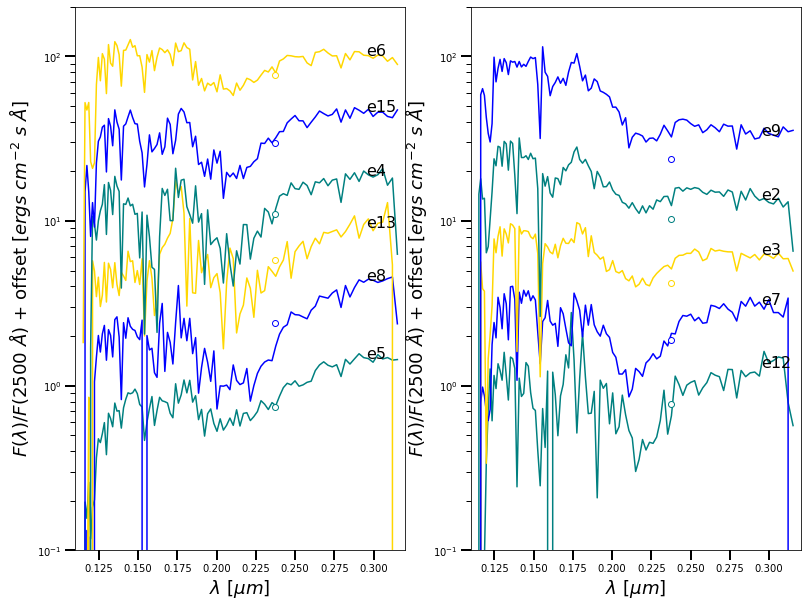

In [4]:
m31_list = [
# "m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope
"m31_e2_j004413.84+414903.9",
"m31_e3_j004420.52+411751.1",
"m31_e4_j004427.47+415150.0",
"m31_e5_j004431.66+413612.4",
"m31_e6_j004438.71+415553.5",
"m31_e7_j004454.37+412823.9",
"m31_e8_j004511.82+415025.3",
"m31_e9_j004511.85+413712.9", # some problem with walkers
# "m31_e10_j004512.73+413726.4", # No STIS data
# "m31_e11_j004535.40+414431.5", # No STIS data
"m31_e12_j004539.00+415439.0",
"m31_e13_j004539.70+415054.8",
# "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
"m31_e15_j004546.81+415431.7",
]
# Only 6, 3, 2, 15 were uncommented before

# Measure the UV slope so spectra can be ordered by it
slopes = []
for i, st in enumerate(m31_list):
    starname = st
    fstarname = f"{starname}.dat"
    starstr = starname.split("m31_")[1].split("_")[0]

    reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

    v1 = np.logical_and(
                reddened_star.data["STIS"].waves > 0.125 * u.micron,
                reddened_star.data["STIS"].waves < 0.145 * u.micron,
            )
#     vr1 = np.logical_and(v1, reddened_star.data["STIS"].npts > 0)
    v2 = np.logical_and(
                reddened_star.data["STIS"].waves > 0.25 * u.micron,
                reddened_star.data["STIS"].waves < 0.30 * u.micron,
            )
#     vr2 = np.logical_and(v2, reddened_star.data["STIS"].npts > 0)
#     print(starstr)
#     print("med.flux v1", np.median(reddened_star.data["STIS"].fluxes[v1]))
#     print("med flux v2", np.median(reddened_star.data["STIS"].fluxes[v2]))
          
    slopes.append(
                np.median(reddened_star.data["STIS"].fluxes[v1])
                / np.median(reddened_star.data["STIS"].fluxes[v2])
            )

# Order stars by UV slope
print("type m31_list", type(m31_list))
m31_list_arr = np.array(m31_list)
print("type m31_list_arr", type(m31_list_arr))
print("m31_list_arr", m31_list_arr)
print("slopes", slopes)
m31_list_uvsort = m31_list_arr[np.argsort(slopes)]

# ============================================================================
fs=14
norm_data = np.average(red_star.data["BAND"].fluxes)
# norm_flux = red_star.data[cspec].fluxes / norm_data

# Define normalization WL
norm_wr = [0.24, 0.26] * u.micron
gres = 100 # Rebin res
rwaverange = [0.11, 0.32] * u.micron

colors = cycle(['teal', 'blue', 'gold'])

plot_one=False
yoffset_init=3000
yot='multiply'
half_num = len(m31_list) // 2 + 1

# fig, ax = plt.subplots(figsize=(13, 20))
fig, ax = plt.subplots(ncols=2, figsize=(13, 10))
# Choose whether to use the UV-slope-sorted list
for i, st in enumerate(m31_list_uvsort): # m31_list_uvsort
    if plot_one:
        fstarname = f"{starname}.dat"
    else:
        starname = st
        print(starname)
        fstarname = f"{starname}.dat"
    starstr = starname.split("m31_")[1].split("_")[0]

    reddened_star, band_names, data_names = get_red_star(fstarname, file_path)
    
    # Remove negative fluxes
    nvals = reddened_star.data["STIS"].fluxes < 0
    reddened_star.data["STIS"].npts[nvals] = 0

    # Rebin spectra
    reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

    # If the entry is in the list's second half, offset by a number near star index
    if i // half_num > 0:
        offset = 2.5 ** (i - half_num)
        annotate_yoffset = 2.5 ** (0.05*(i - half_num))
    else:
        offset = 2.5 ** i
        annotate_yoffset = 2.5 ** (0.05*i)
    annotate_yoffset = 0.0
    reddened_star.plot(ax[i // half_num], 
                       pcolor=next(colors), 
                       yoffset=offset, 
                       yoffset_type=yot,
                       norm_wave_range=norm_wr,
                        annotate_key="STIS",
                        annotate_wave_range=[0.29, 0.3] * u.micron,
                        annotate_text=starstr,
                        annotate_rotation=-0.0,
                        annotate_yoffset=0.0,
                        fontsize=16)

for i in range(2):
    ax[i].set_xlim(0.11, 0.32)
    ylim = ax[i].get_ylim()
    ax[i].set_ylim(1e-1, 200)
    ax[i].set_xscale("linear")
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fs)
    ax[i].set_ylabel(
            r"$F(\lambda)/F(2500~\AA)$ + offset [$ergs\ cm^{-2}\ s\ \AA$]",
            fontsize=1.3 * fs,
        )
    ax[i].tick_params("both", length=10, width=2, which="major")
    ax[i].tick_params("both", length=5, width=1, which="minor")

# ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fs)
# ax.tick_params("both", length=10, width=2, which="major")
# ax.tick_params("both", length=5, width=1, which="minor")

# plt.savefig(savefile_path + "spectra_offset/z35_uvsort_" + str(gres) + "res_no_norm.pdf")

In [8]:
gres = 100
rwaverange = [0.11, 0.32] * u.micron
print("fstarname", fstarname)

fstarname m31_e2_j004413.84+414903.9.dat


NameError: name 'modinfo' is not defined

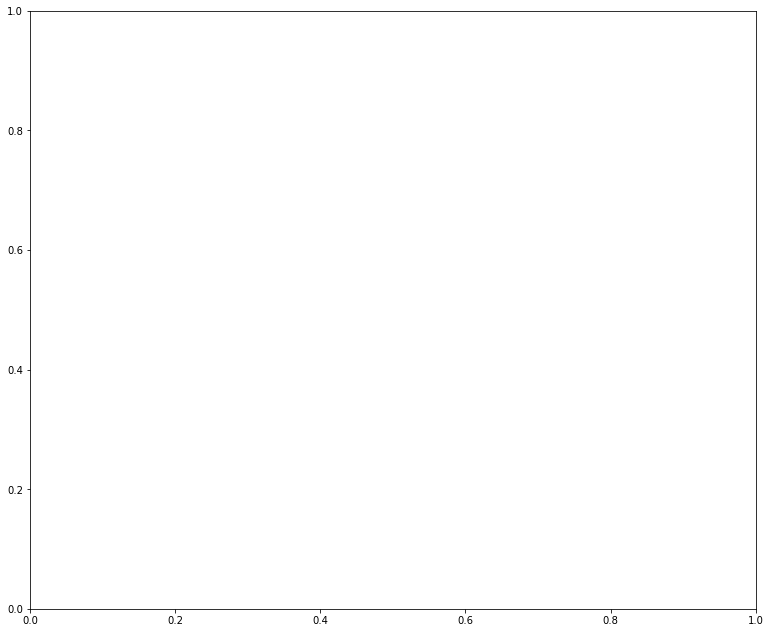

In [3]:
# Test plotting intrinsic model SED, rebinned and not
fig, ax = plt.subplots(figsize=(13, 11))
n=5
#Try 10 model fluxes
for i in range(n):
    ax.plot(
        modinfo.waves["STIS"], 
        modinfo.fluxes["STIS"][i], 
        )
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][i], 
        'k')
  
# plt.savefig(savefile_path + "rebinned_models/1_" + str(n) + "_rebinned_mod_" + str(gres) + "res.pdf")

fig, ax = plt.subplots(figsize=(13, 11))

#Try 10 model fluxes
for i in range(n):
    ax.plot(
        modinfo_rb.waves["STIS"], 
        modinfo_rb.fluxes["STIS"][i], 
        )
    
print("waves", modinfo_rb.waves["STIS"][0:50])

Create the weight arrays based on the observed uncertainties

In [3]:
def set_weights(data_names, reddened_star):
    """
    """
    # cropping info for weights
    #  bad regions are defined as those where we know the models do not work
    #  or the data is bad
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
    ex_regions = [
        [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
        [8.7, 10.0],  # bad data from STIS
        [3.55, 3.6],
        [3.80, 3.90],
        [4.15, 4.3],
        [6.4, 6.6],
        [7.1, 7.3],
        [7.45, 7.55],
        [7.65, 7.75],
        [7.9, 7.95],
        [8.05, 8.1],
    ] / u.micron

    weights = {}
    for cspec in data_names:
        weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
        gvals = reddened_star.data[cspec].npts > 0
        weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

        x = 1.0 / reddened_star.data[cspec].waves
        for cexreg in ex_regions:
            weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

    # make the photometric bands have higher weight
    weights["BAND"] *= 10000.0
    print("weight arrays set")
    return weights

### Setup the fit parameters

In [4]:
def setparams(modinfo, logt=4.25, logg=3.09, logz=0.0, av=0.75, rv=3.1, c2=2.5, c3=0.65, c4=0.26, \
              x0=4.66, g=0.86 , hig=21.0, himw=19.0):
    """
    """
    # parameter names
    pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # initial starting position
    #  **customize for each star**
    # SMC metallicity -> 0.2 (1/5 solar)
    # Original params list
    # params = [4.25, 3.09, 0.2, 0.75, 3.7, 2.5, 0.65, 0.26, 4.66, 0.86, 22.0, 19.0]

    params = [logt, logg, logz, av, rv, c2, c3, c4, x0, g, hig, himw]

    # min/max allowed values for each parameter
    # some are based on the min/max of the stellar atmosphere grid
    plimits = [
            [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
            [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
            [modinfo.mets_min, modinfo.mets_max],    # log(Z)
            [0.0, 4.0],   # Av
            [2.0, 6.0],   # Rv
            [-0.1, 5.0],  # C2
            [0.0, 2.5],   # C3
            [0.0, 1.0],   # C4
            [4.5, 4.9],   # xo
            [0.6, 1.5],   # gamma
            [17.0, 24.0], # log(HI) internal to galaxy
            [17.0, 22.0], # log(HI) MW foreground
        ]

    # add Gaussian priors based on prior knowledge
    #  sptype -> log(Teff), log(g)
    #  galaxy metallicity -> log(Z)
    print("Priors are logT={}, logg={}, logZ={}".format(logt, logg, logz))
    ppriors = {}
    ppriors["logT"] = (logt, 0.1)
    ppriors["logg"] = (logg, 0.1)
    ppriors["logZ"] = (logz, 0.1)

    return pnames, params, plimits, ppriors    

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [5]:
def package_fitinfo(pnames, plimits, weights, ppriors, velocity):
    """
    """
    ppriors=None
    fitinfo = FitInfo(
        pnames,
        plimits,
        weights,
        parameter_priors=ppriors,
        stellar_velocity=velocity,
    )
    return fitinfo

#### Turn log(likelihood) into chi^2
Needed since op.minimize searchs for the min chisqr (not max likelihood like MCMC algorithms)

In [7]:
def nll(*args):
    return -fitinfo.lnprob(*args)

# simple function to turn the log(likelihood) into the chisqr
# requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def log_l_to_chi2(fitinfo, params, reddened_star, modinfo, method="Nelder-Mead"): #, maxiter
    """
    nll = function to be minimized
    params = initial guess
    method = type of solver
    args = extra arguments passed to the fn to be minimized
    """
# result = op.minimize(
#    nll, params, method="Nelder-Mead", args=(reddened_star, modinfo, fitinfo)
# def lnprob(params, obsdata, modeldata, fitinfo):

    # run the fit
#     nll_w_fitinfo = -fitinfo.lnprob(reddened_star, modinfo, fitinfo)
    result = op.minimize(
        nll, params, method="Nelder-Mead", 
        args=(reddened_star, modinfo, fitinfo), options={"maxiter": 1000})
    
    # check the fit output
    print("in log_l_to_chi2.", result["message"])
    print("Success?", result["success"])
    return result

### Save dust param results based on optimizer calc

In [8]:
def save_results(result, pnames, print=False):
    """
    """
    params = result["x"]
    fit_params = params
    params_best = params
    pnames_extra = pnames

    if print:
        print("Best fit")
        for k, val in enumerate(params_best):
            print("{} # {}".format(val, pnames_extra[k]))
        
    return params, fit_params, params_best, pnames_extra

#### Calculate and save the extinction curve (longer version)

In [9]:
def calc_plot_ext_curve(modinfo,
                        fit_params, 
                        velocity, 
                        relband, 
                        reddened_star, 
                        starname, 
                        params, 
                        starstr,
                        save_ext_curve,
                        plot_ext_curve):
    """
    """
    # intrinsic sed: log(T), log(g), Z, Av
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed: Av, etc.
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
#     Calculate the E(lambda-X) for the photometric band data
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    
    if save_ext_curve:
        print("Saving extinction curve")
        extdata.save("extcurves/" + starstr + "_ext_rb_" + str(gres) + "res.fits", column_info=col_info)
        print("extinction curve type", extdata.type)
    
    # =============== PLOT the extinction curve =========================
    if plot_ext_curve:
        fig, ax = plt.subplots(figsize=(13, 10))

        # convert from E(l-V) to A(l)/A(V)
        # print(extdata.type_rel_band != "V")
        extdata.columns["AV"] = (params[3], 0.0)
        # extdata.trans_elv_alav()
        # extdata.trans_elv_elvebv()

        extdata.plot(ax, color='deepskyblue')#, alax=True)
        ax.set_xscale("log")
        ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
        # ax.set_ylim(0.0, 10.0)
        ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
        ax.tick_params("both", length=10, width=2, which="major")
        ax.tick_params("both", length=5, width=1, which="minor")

        # plot known exitnction curves
        mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
        smcbar = G03_SMCBar()
        Af475wAv = smcbar(0.475 * u.micron)
        smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

        f19_rv31 = F19(Rv=3.1)
        Af475wAv = f19_rv31(0.475 * u.micron)
        f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
        ax.plot(1.0 / mod_x, f19_el475w, "k-", lw=0.5)

        ax.set_title("%s" % starname)
        plt.savefig(savefile_path + "ext_curves/" + starstr + "_extcurve_" + str(gres) + "_res.png")
    
    return modsed, ext_modsed, hi_ext_modsed, modsed_stardata, extdata, col_info

### Save ext curve (quick, no optimizer needed)

In [ ]:
def save_ext_curve_quick():
    """
    """# intrinsic sed
    modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        fit_params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    modsed_stardata = modinfo.SED_to_StarData(modsed)

    # create an extincion curve and save it
    extdata = ExtData()
    extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
    col_info = {"av": fit_params[3], "rv": fit_params[4]}
    extdata.save(starname + "_ext.fits", column_info=col_info)

In [18]:
print(rwaverange)
print(gres)

[0.1  0.32] micron
150


### Read initial positions from file

In [10]:
def read_init_pos(starstr):
    """
    Read in the params specifying the best-fit intial position
    """
    
    print("\nstarname", starname, "\n")
    initial_pos_file = "initial_pos/" + starstr + "_start.dat" 
    ipdata = np.fromfile(initial_pos_file, dtype="float", sep=" ")
    
    if len(ipdata) < 12 or len(ipdata) > 12:
        print("WARNING: Initial position data has fewer/more elements than expected.")

    logtgrid = [ipdata[0]]
    logggrid = [ipdata[1]]
    logzgrid = [ipdata[2]]
    avgrid = [ipdata[3]]
    rvgrid = [ipdata[4]]
    c2grid = [ipdata[5]]
    c3grid = [ipdata[6]]
    c4grid = [ipdata[7]]
    x0grid = [ipdata[8]]
    gammagrid = [ipdata[9]]
    hi_galgrid = [ipdata[10]]
    hi_mwgrid = [ipdata[11]]

    return logtgrid, logggrid, logzgrid, \
            avgrid, rvgrid, c2grid, c3grid, \
            c4grid, x0grid, gammagrid, \
            hi_galgrid, hi_mwgrid


### Set up parameter grid ranges

In [11]:
def setup_param_ranges(starname, starstr, small_vary=False):
    """
    """
    print("starname", starname)
    print("starstr", starstr)
    singlevalued = True

    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

    # Get initial positions
    logtgrid, logggrid, logzgrid, \
        avgrid, rvgrid, c2grid, c3grid, \
        c4grid, x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = read_init_pos(starstr)
    
    initial_grid = [logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, \
                    c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid]
    
    if singlevalued is False:
        # Introduce a small variation around the orig initial pos.
        if small_vary:
            print("small vary")
# log(T) [4.11 4.31]
# log(g) [2.55 2.85]
# log(Z) [-0.1  0.1]
# Av [0.9 1.1]
# Rv [3.1]
# c2 [1.2 1.4]
# c3 [2.  2.2 2.4]
# c4 [-0.11  0.09]
# x0 [4.55 4.6 ]
# gamma [0.65 0.85]
# HI_gal [20. 21.]
# HI_MW [18. 19.]
            logtgrid = np.arange(logtgrid[0]-0.15, logtgrid[0]+0.15, 0.2)
            logggrid = np.arange(logggrid[0]-0.2, logggrid[0]+0.2, 0.3)
            logzgrid = np.arange(-0.1, 0.2, 0.2)
            avgrid = np.arange(avgrid[0]-0.2, avgrid[0]+0.2, 0.2)
            rvgrid = [rvgrid[0]]
            c2grid = np.arange(c2grid[0]-0.2, c2grid[0]+0.2, 0.2) 
            c3grid = np.arange(c3grid[0]-0.15, c3grid[0]+0.15, 0.2)  
            if starstr == "e7":
                print("c4, e7")
                c4grid = np.arange(c4grid[0]-0.05, c4grid[0]+0.4, 0.3)
            elif starstr == 'e9':
                print("c4, e9, c4grid[0]", c4grid[0])
                c4grid = np.arange(c4grid[0]+0.03, c4grid[0]+0.6, 0.3)
            else:
                c4grid = np.arange(c4grid[0]-0.2, c4grid[0]+0.2, 0.2)
            x0grid = np.arange(x0grid[0]-0.05, x0grid[0]+0.05, 0.05)
            gammagrid = np.arange(gammagrid[0]-0.2, gammagrid[0]+0.1, 0.2)
            if starstr == "e8":
                hi_galgrid = np.arange(hi_galgrid[0], hi_galgrid[0]+1, 0.5)
                hi_mwgrid = np.arange(hi_mwgrid[0], hi_mwgrid[0]+1, 0.5)
            else:
                hi_galgrid = np.arange(hi_galgrid[0]-1, hi_galgrid[0]+1, 1)
                hi_mwgrid = np.arange(hi_mwgrid[0]-1, hi_mwgrid[0]+1, 1)
        else:
            logtgrid = np.arange(4.4, 4.43, 0.02);    logggrid = np.arange(2.75, 3., 0.5)
            logzgrid = np.arange(-0.3, 0.4, 0.1);    avgrid = np.arange(1.2, 1.3, 0.05)
            rvgrid = np.arange(3.1, 3.15, 0.1);    c2grid = np.arange(1.3, 1.4, 0.1) 
            c3grid = np.arange(2.2, 2.3, 0.1);    c4grid = np.arange(0.05, 0.075, 0.01)
            x0grid = np.arange(4.65, 4.71, 0.05);    gammagrid = np.arange(0.9, 0.91, 0.05)

    print("log(T)", logtgrid)
    print("log(g)", logggrid)
    print("log(Z)", logzgrid)
    print("Av", avgrid)
    print("Rv", rvgrid)
    print("c2", c2grid)
    print("c3", c3grid)
    print("c4", c4grid)
    print("x0", x0grid)
    print("gamma", gammagrid)
    print("HI_gal", hi_galgrid)
    print("HI_MW", hi_mwgrid)

    n_combos = len(logtgrid) * len(logggrid) * len(avgrid) * len(logzgrid) * \
                len(c2grid) * len(c3grid) * len(c4grid) * len(x0grid) * \
                len(gammagrid) * len(rvgrid) * len(hi_galgrid) * len(hi_mwgrid)
    print("\nRun generates %s combination(s)" % n_combos)

    if n_combos > 2500:
        print("WARNING: Number of combinations is greater than 2500.")
    else:
        return initial_grid, logtgrid, logggrid, logzgrid, avgrid, rvgrid, c2grid, c3grid, c4grid, x0grid, gammagrid, hi_galgrid, hi_mwgrid

### Plot spectra: Intrinsic, Observations, Dust-extinguished

In [12]:
def plot_spectra_with_mod(modinfo, hi_ext_modsed, reddened_star, modsed, ext_modsed, \
                          modsed_stardata, starstr, params, initial_grid):
    """
    """
    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes)

    # plotting setup for easier to read plots
    fontsize = 16
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, ax = plt.subplots(figsize=(14, 12))

    # plot the bands and all spectra for this star
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves, weights[cspec], 'k-')

        # Observations
        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes / norm_data,
            "k" + ptype,
            label="data",
        )

        # Intrinsic SED
#         print("test rebinned intrinsic wavelengths", modinfo.waves[cspec])
#         print("test rebinned intrinsic fluxes", modsed[cspec] / norm_model)
        ax.plot(
            modinfo.waves[cspec], 
            modsed[cspec] / norm_model, 
            "b" + ptype, label=cspec
        )
        
        # dust_extinguished sed
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] / norm_model,
            "r" + ptype,
            label=cspec,
        )
        
        # hi abs sed
        ax.plot(
            modinfo.waves[cspec],
            hi_ext_modsed[cspec] / norm_model,
            "g" + ptype,
            label=cspec,
        )

    # finish configuring the plot
#     ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()
    
    # pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4",
    #"x0","gamma","HI_gal","HI_mw"]
#     print("params in plot_spectra_with_mod()", params)
    logt_round = np.around(params[0], decimals=2)
    logg_round = np.around(params[1], decimals=2)
    logz_round = np.around(params[2], decimals=2)
    av_round = np.around(params[3], decimals=2)
    rv_round = np.around(params[4], decimals=2)
    c2_round = np.around(params[5], decimals=2)
    c3_round = np.around(params[6], decimals=2)
    c4_round = np.around(params[7], decimals=2)
    x0_round = np.around(params[8], decimals=2)
    g_round = np.around(params[9], decimals=2)
    higal_round = np.around(params[10], decimals=2)
    himw_round = np.around(params[11], decimals=2)
    print("Fig params are log(T)=%s, log(g)=%s, Av=%s" % (params[0], params[1], params[3]))
    
    # Generate a name to record the star and its parameters
    param_combo_str = "_T_" + str(logt_round)  + "_g_" + str(logg_round) + \
                "_Z_" + str(logz_round) + \
                "_Av_"  + str(av_round) + "_Rv_" + str(rv_round) + "_c2_" + \
                str(c2_round) + "_c3_" + str(c3_round) + "_c4_" + str(c4_round) + "_x_" + \
                str(x0_round) + "_gam_" + str(g_round) + \
                "_HIgal_" + str(higal_round) + "_HImw_" + str(himw_round)
    print("star", starstr)
    
#     ax.set_title(starstr + param_combo_str, y=0.95, fontsize=13)
    
    # Title with initial value for initial pos
    param_combo_str_init = "_T_" + str(initial_grid[0][0])  + "_g_" + str(initial_grid[1][0]) + \
                "_Z_" + str(initial_grid[2][0]) + \
                "_Av_"  + str(initial_grid[3][0]) + "_Rv_" + str(initial_grid[4][0]) + "_c2_" + \
                str(initial_grid[5][0]) + "_c3_" + str(initial_grid[6][0]) + "_c4_" + str(initial_grid[7][0]) + "_x_" + \
                str(initial_grid[8][0]) + "_gam_" + str(initial_grid[9][0]) + \
                "_HIgal_" + str(initial_grid[10][0]) + "_HImw_" + str(initial_grid[11][0])

    # Set title to updated initial position, param_combo_str
    ax.set_title(starstr + param_combo_str, y=0.95, fontsize=15)
    
    if 'e6' in fstarname:
        ax.set_xlim(0.1, 1)
#     elif 'e2' in fstarname:
    ax.set_ylim(0.01, 250)

#     plt.savefig(savefile_path + "spectra_w_mod/" + starstr + "_rb_" +  str(gres) + "_res.png")
    plt.savefig(savefile_path + "starting_positions_retry/" + str(starstr) + "/" + starstr + "_rb_" +  \
                str(gres) + param_combo_str + ".png")
    print("Saved spectra w mod")
#     plt.close()

### Driver code calling all functions to calculate the extinction curve:
#### 1. Sets weight arrays
#### 2. Sets parameters
#### 3. Packages fitinfo
#### 4. log(likelihood) to the chisqr
#### 5. Saves result and prints best fit from initial guess
#### 6. Calculates extinction curve

In [91]:
def do_calc(initial_grid, singlevalued, get_uncert=False, save_ext_curve=False,
            plot_ext_curve=False):
    """
    """
    method="Nelder-Mead"#"Powell" 
    starstr = starname.split("m31_")[1].split("_")[0]
    print("star_str", starstr)
    outfolder = "fit_/"

    # if not os.path.isdir(outfolder):
    #     print("making new dir", (outfolder))
    #     os.system("mkdir " + savefile_path + outfolder)

    # Create weight arrays
    weights = set_weights(data_names, reddened_star)

    if singlevalued:
        print("single-valued...")
        pnames, params, \
        plimits, ppriors = setparams(modinfo_rb, logtgrid[0], logggrid[0], 
                                     logzgrid[0], av=avgrid[0], rv=rvgrid[0],
                                     c2=c2grid[0], c3=c3grid[0], c4=c4grid[0], 
                                     x0=x0grid[0], g=gammagrid[0], hig=hi_galgrid[0], 
                                     himw=hi_mwgrid[0])

        fitinfo = package_fitinfo(pnames, plimits, weights, ppriors, velocity)
        # Get result inline
        def nll(*args):
            return -fitinfo.lnprob(*args)
        
        # Run MCMC sampler here to get ext curve params uncertainties
        if get_uncert:
            print("Starting MCMC sampler")
            mc_sampler(pnames, params, reddened_star, fitinfo)
            print("Done running MCMC sampler for uncert.")
            
            # Run optimizer to get result
            result = op.minimize(nll, params, method="Nelder-Mead", 
                                 args=(reddened_star, modinfo_rb, fitinfo), 
                                 options={"maxiter": 1000})

            params_opt, fit_params, params_best, pnames_extra = save_results(result, pnames)
            
            # long save ext curve
            if save_ext_curve or plot_ext_curve:
                modsed, ext_modsed, \
                hi_ext_modsed, modsed_stardata, \
                extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve)
    
        # Or run the optimizer
        else:
            # simple function to turn the log(likelihood) into the chisqr
            # requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
            #         nll = function to be minimized
            #         params = initial guess
            #         method = type of solver
            #         args = extra arguments passed to the fn to be minimized

            # run the fit
            result = op.minimize(
                nll, params, method="Nelder-Mead", 
                args=(reddened_star, modinfo_rb, fitinfo), options={"maxiter": 1000})

            # check the fit output
            print("in log_l_to_chi2.", result["message"])
            print("Success?", result["success"])

            # Get result via a separate fn: does not work right now
            # result = log_l_to_chi2(fitinfo, params, reddened_star, 
            #                        modinfo=modinfo_rb, method=method)

            params_opt, fit_params, params_best, pnames_extra = save_results(result, pnames)

            modsed, ext_modsed, \
            hi_ext_modsed, modsed_stardata, \
            extdata, col_info = calc_plot_ext_curve(modinfo_rb, fit_params, 
                                                    velocity, relband, 
                                                    reddened_star, starname, 
                                                    params_opt, starstr,
                                                    save_ext_curve,
                                                    plot_ext_curve)

            # Plot obs & mod spectra (based on initial guess), and save it
            plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                           modsed_stardata, starstr, params, initial_grid)

    else:
        for i in range(len(logtgrid)):
            for j in range(len(logggrid)):
                for k in range(len(logzgrid)):
                    for l in range(len(avgrid)):
                        for m in range(len(rvgrid)):
                            for n in range(len(c2grid)):
                                for o in range(len(c3grid)):
                                    for p in range(len(c4grid)):
                                        for q in range(len(x0grid)):
                                            for r in range(len(gammagrid)):
                                                for s in range(len(hi_galgrid)):
                                                    for t in range(len(hi_mwgrid)):
                                                        pnames, \
                                                        params, \
                                                        plimits, \
                                                        ppriors = setparams(modinfo_rb,
                                                                            logtgrid[i],
                                                                            logggrid[j],
                                                                            logzgrid[k],
                                                                            av=avgrid[l],
                                                                            rv=rvgrid[m],
                                                                            c2=c2grid[n], 
                                                                            c3=c3grid[o],
                                                                            c4=c4grid[p],
                                                                            x0=x0grid[q],
                                                                            g=gammagrid[r],
                                                                            hig=hi_galgrid[s], 
                                                                            himw=hi_mwgrid[t])
                                                
                                                fitinfo = package_fitinfo(pnames, plimits, 
                                                                          weights, ppriors, 
                                                                          velocity)

                                                # for e3 crashes with maxiter > 15
    #                                             result = log_l_to_chi2(fitinfo, 
    #                                                                    params, 
    #                                                                    reddened_star, 
    #                                                                    modinfo=modinfo_rb,
    #                                                                    method=method)
                                                # Get result inline
                                                def nll(*args):
                                                    return -fitinfo.lnprob(*args)

                                                # run the fit
                                                result = op.minimize(nll,
                                                                     params, 
                                                                     method="Nelder-Mead", 
                                                                     args=(reddened_star, modinfo_rb, fitinfo),
                                                                     options={"maxiter": 1000})

                                                params_opt, \
                                                fit_params, \
                                                params_best, \
                                                pnames_extra = save_results(result, pnames)

                                                modsed, \
                                                ext_modsed, \
                                                hi_ext_modsed, \
                                                modsed_stardata, \
                                                extdata, \
                                                col_info = calc_plot_ext_curve(modinfo_rb, fit_params, velocity, 
                                                                          relband, reddened_star, 
                                                                          starname, params_opt, starstr,
                                                                          save_ext_curve, plot_ext_curve)

                                                # Plot obs & mod spectra (based on initial guess), and save it
                                                plot_spectra_with_mod(modinfo_rb, hi_ext_modsed, reddened_star, modsed, ext_modsed, 
                                                               modsed_stardata, starstr, params, initial_grid)

                                                print('\n\n')

### Get Ext Curves or Initial Position one by one

In [ ]:
m31_list = [
#     "m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope
                                # MCMC fitter error:
#     UnboundLocalError: local variable 'fit_params_best' referenced before assignment
#     "m31_e2_j004413.84+414903.9",
#     "m31_e3_j004420.52+411751.1", # ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance
#     "m31_e4_j004427.47+415150.0",
#     "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # MCMC fitter error:
        # UnboundLocalError: local variable 'fit_params_best' referenced before assignment
#     "m31_e7_j004454.37+412823.9",
#     "m31_e8_j004511.82+415025.3",
    "m31_e9_j004511.85+413712.9", # some problem with walkers
#     "m31_e12_j004539.00+415439.0",
#     "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
#     "m31_e15_j004546.81+415431.7",
]

# Matching model rebin
# rwaverange = [0.1, 0.32] * u.micron
# gres = 150
# gres = 100
# rwaverange = [0.11, 0.32] * u.micron
# print("rwaverange/gres", rwaverange, gres)

# Calculates all extinction curves
doall=True
singlevalued=True
save_ext_curve=True,
plot_ext_curve=True
# The following will run the MCMC sampler if set to True
get_uncert=True

if doall:
    for i, s in enumerate(m31_list):
        starname = m31_list[i]
        starstr = starname.split("m31_")[1].split("_")[0]

#         print(starname)
        fstarname = f"{starname}.dat"

        #def get_red_star(fstarname, file_path, excl_zero=True, rebin=True, rbres=750)
        reddened_star, band_names, data_names = get_red_star(fstarname, file_path)

        # Remove negative fluxes
        nvals = reddened_star.data["STIS"].fluxes < 0
        reddened_star.data["STIS"].npts[nvals] = 0

        # Rebin spectra
        reddened_star.data["STIS"].rebin_constres(rwaverange, gres)

#         print("data length", len(reddened_star.data["STIS"].npts))
#         print("model length", len(modinfo_rb.waves["STIS"]))

        initial_grid, logtgrid, logggrid, \
        logzgrid, avgrid, \
        rvgrid, c2grid, \
        c3grid, c4grid, \
        x0grid, gammagrid, \
        hi_galgrid, hi_mwgrid = setup_param_ranges(starname, starstr, small_vary=False)

        do_calc(initial_grid, 
                singlevalued, 
                get_uncert, 
                save_ext_curve,
                plot_ext_curve)

starname m31_e9_j004511.85+413712.9
starstr e9

starname m31_e9_j004511.85+413712.9 

log(T) [4.75]
log(g) [2.85]
log(Z) [-0.1]
Av [0.85]
Rv [3.1]
c2 [1.1]
c3 [2.45]
c4 [0.37]
x0 [4.55]
gamma [0.85]
HI_gal [20.0]
HI_MW [20.5]

Run generates 1 combination(s)
star_str e9
weight arrays set
single-valued...
Priors are logT=4.75, logg=2.85, logZ=-0.1
Starting MCMC sampler
START burning in walkers


/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


DONE burning in walkers
START burning in walkers AFTER sampler reset


### MCMC Driver

### Run emcee MCMC sampler to define uncertainties (bonus section)

In [102]:
def mc_sampler(pnames, params, reddened_star, fitinfo):
    """
    """
    p0 = params
    ndim = len(p0)
#     print("p0", p0)

    #nwalkers = 2 * ndim
    #nsteps = 50
    #burn = 50

    nwalkers = 100
    nsteps = 500 #10,000
    burn = 500

    # setting up the walkers to start "near" the inital guess
    p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

    # setup the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo_rb, fitinfo)
    )

    # burn in the walkers
    print("START burning in walkers")
    pos, prob, state = sampler.run_mcmc(p, burn)
    print("DONE burning in walkers")
    
    # reset the sampler
    sampler.reset()

    # do the full sampling
    print("START burning in walkers AFTER sampler reset")
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    print("DONE burning in walkers AFTER sampler reset")
    # print ("pos", pos)
    # print ("prob", prob)
    # print ("state", state)

    # create the samples variable for later use
    print("Creating samples variable for later use")
    samples = sampler.chain.reshape((-1, ndim))
    print("DONE creating samples variable for later use")
    print("len samples", len(samples))

    # get the best fit values
    pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
    params_best = get_best_fit_params(sampler)
    fit_params = params_best
    print("star", starstr)
    print("best params")
    print(params_best)

    # get the 16, 50, and 84 percentiles
    params_per = get_percentile_params(samples)
    print("params_per")
    print(params_per)

    for k, val in enumerate(params_per):
        print(
            "{} {} {} {} # {}".format(
                params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
    
    # save params in a dat file
    save_mcmc_params(starstr, params_best, params_per, pnames_extra)

### Record best fit params + uncert. to dat file

In [103]:
def save_mcmc_params(starstr, params_best, params_per, pnames_extra):
    """
    """
    # save the best fit and p50 +/- uncs values to a file
    # save as a single row table to provide a uniform format
    f = open("params_dat/" + starstr + "_fit_params.dat", "w")
    #f.write("# best fit, p50, +unc, -unc\n")

#     pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
#     params_per = get_percentile_params(samples)

    print("saving params...")
    for k, val in enumerate(params_per):
        f.write(
            "{} {} {} {} # {}\n".format(
               params_best[k], val[0], val[1], val[2], pnames_extra[k]
            )
        )
        print("done writing params")
    f.close()

### Calc & save ext curve with new best fit params
#### (now fit_params = params; also params_best = params &  pnames_extra = pnames)

In [166]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save("extcurves/" + starstr + "_ext.fits", column_info=col_info)

[1.20165640e+09 1.20119364e+09 1.13232144e+09 ... 9.35450100e+07
 9.31554505e+07 9.27500119e+07] erg / (Angstrom cm2 s)


### Plot new best-fit model spectra

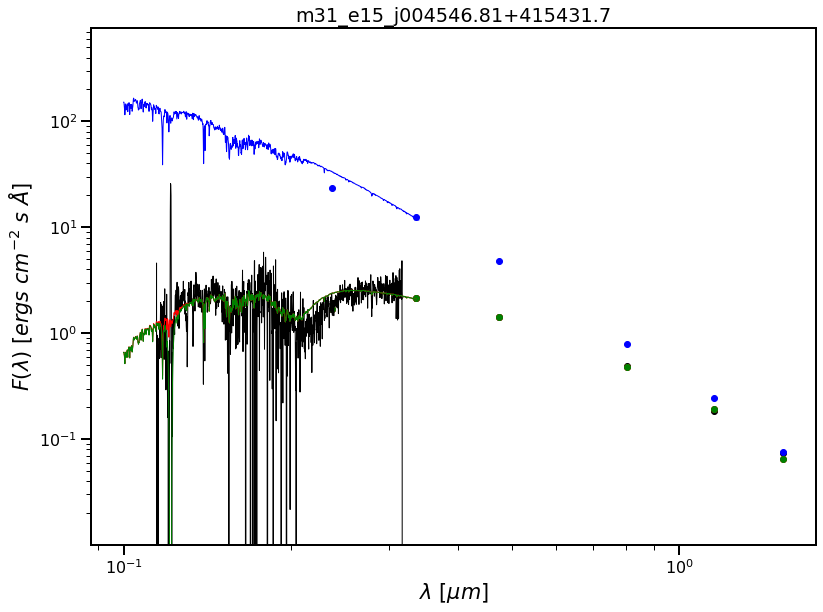

In [167]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 16
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 9.5))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 6e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
# fig.tight_layout()
plt.title(starname)
plt.savefig(savefile_path + starstr + "_spectra2" + ".png")

### Plot new best-fit extinction curve

True


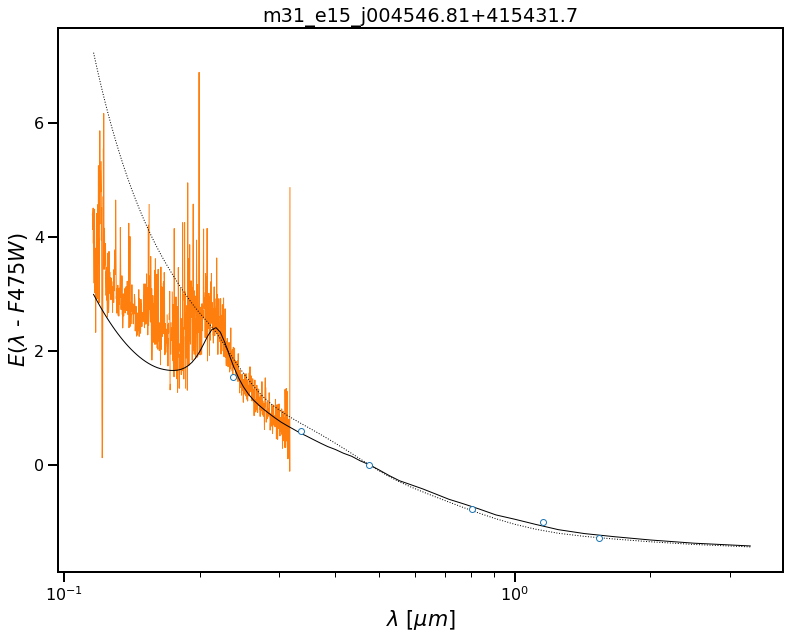

In [168]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
# extdata.trans_elv_alav()

# def trans_elv_elvebv
extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
#ax.set_ylim(0.0, 10.0)
# ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.set_ylabel(fr"$E(\lambda$ - %s)" % relband_str, fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
# ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")
Af475wAv = smcbar(0.475 * u.micron)
smcbar_el475w = (smcbar(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, smcbar_el475w, "k:")

f19_rv31 = F19(Rv=3.1)
# ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")
# ax.set_xlim(0, 7.5)
Af475wAv = f19_rv31(0.475 * u.micron)
f19_el475w = (f19_rv31(mod_x) - Af475wAv) * params[3]
ax.plot(1.0 / mod_x, f19_el475w, "k-")
plt.title(starname)
plt.savefig(savefile_path + starstr + "_extcurve2" + ".png")


## Plot ext curve param results (put at end)

In [80]:
m31_results = [
    #"m31_e1_j004354.05+412626.0", # Prob. w sorting by UV slope; bad fit, no uncert. results
    "m31_e2_j004413.84+414903.9",
    "m31_e3_j004420.52+411751.1",
    "m31_e4_j004427.47+415150.0",
    "m31_e5_j004431.66+413612.4",
#     "m31_e6_j004438.71+415553.5", # bad fit, no uncert. results
    "m31_e7_j004454.37+412823.9",
    "m31_e8_j004511.82+415025.3",
#     "m31_e9_j004511.85+413712.9", # some problem with walkers
    "m31_e12_j004539.00+415439.0",
    "m31_e13_j004539.70+415054.8",
#     "m31_e14_j004543.46+414513.6", # Prob. w sorting by UV slope
    "m31_e15_j004546.81+415431.7",
]

# best fit, p50, p50 + 1sig, p50 - 1sig
logt=[]; logtp50=[]; logtp1sig=[]; logtm1sig=[]
logg=[]; loggp50=[]; loggp1sig=[]; loggm1sig=[]
logz=[]; logzp50=[]; logzp1sig=[]; logzm1sig=[]
av=[]; avp50=[]; avp1sig=[]; avm1sig=[]
rv=[]; rvp50=[]; rvp1sig=[]; rvm1sig=[]
c2=[]; c2p50=[]; c2p1sig=[]; c2m1sig=[]
c3=[]; c3p50=[]; c3p1sig=[]; c3m1sig=[]
c4=[]; c4p50=[]; c4p1sig=[]; c4m1sig=[]
x0=[]; x0p50=[]; x0p1sig=[]; x0m1sig=[]
gamma=[]; gammap50=[]; gammap1sig=[]; gammam1sig=[]
higal=[]; higalp50=[]; higalp1sig=[]; higalm1sig=[]
himw=[]; himwp50=[]; himwp1sig=[]; himwm1sig=[]
p1=[];p2=[];p3=[];p4=[];p5=[];p6=[];p7=[];p8=[];p9=[];p10=[];p11=[];p12=[]

p = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
# for k, val in enumerate(params_per):
#     f.write(
#         "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#         )
#     )
#f.write("# best fit, p50, +unc, -unc\n")

# Read in fit values
for i, star in enumerate(m31_results):
    starname = star
    starstr = starname.split("m31_")[1].split("_")[0]
    results_file = "params_dat/" + starstr + "_fit_params.dat"

    with open(results_file) as fin:
        data = (i for i in fin if not i.isspace())
        print("data", data)
        j=0
        for row in data:
            p[j].append(row)
            print(row)
            j+=1
            if j < 7:
                row = next(data)

    print(p)
#     
#     ipdata = np.fromfile(results_file, dtype="float", sep="\n")
#     print(ipdata)
#     logg.append([ipdata[1]])
#     logz.append([ipdata[2]])
#     av.append([ipdata[3]])
#     rv.append([ipdata[4]])
#     c2.append([ipdata[5]])
#     c3.append([ipdata[6]])
#     c4.append([ipdata[7]])
#     x0.append([ipdata[8]])
#     gamma.append([ipdata[9]])
#     HI_gal.append([ipdata[10]])
#     HI_mw.append([ipdata[11]])

data <generator object <genexpr> at 0x7faff6c796d0>
4.66193591387958 4.653809243393445 0.017278194973250116 0.038484524826410293 # logT

0.00041534176311114936 0.0003966513293281468 8.752766101800889e-05 4.392985245847637e-05 # logZ

2.855469747257809 2.8527438668277885 0.019854103910863063 0.009339493802336563 # Rv

1.810913492151281 2.2266113167124586 0.11048282539740528 0.25659864187605486 # C3

4.761866218584217 4.783856784483537 0.015380903948185143 0.0127773486220768 # x0

21.81946881231114 21.854035754094458 0.0508338172162901 0.06212153520898411 # HI_gal

0.33394240918309015 0.33366299454798876 0.00040882947142295567 0.008634415385799177 # E(B-V)

6.920216362198553e+21 7.532577958785516e+21 1.0652309073158608e+21 1.0143047524677992e+21 # N(HI)/A(V)

1.9760468466736455e+22 2.1480895478744048e+22 3.1766486559350797e+21 2.92930063762781e+21 # N(HI)/E(B-V)

[['4.66193591387958 4.653809243393445 0.017278194973250116 0.038484524826410293 # logT\n'], ['0.00041534176311114936 0.0003966


1.54810237010426 1.4781693300399044 0.08745220310440138 0.06127041939899214 # C3

4.672983434836574 4.65473226688266 0.019858815174955247 0.007264818118242644 # x0

23.82451980868602 23.823591427014183 0.04312927117129561 0.019662112898739537 # HI_gal

0.3916750684246331 0.39067983653447175 0.0016617442665516902 0.001362853236763495 # E(B-V)

6.996479322701977e+23 6.94806483852955e+23 7.050844814844109e+22 2.8572441240848497e+22 # N(HI)/A(V)

1.7044877357813934e+24 1.7071582599959418e+24 1.758803908863844e+23 7.796730116257689e+22 # N(HI)/E(B-V)
[['4.66193591387958 4.653809243393445 0.017278194973250116 0.038484524826410293 # logT\n', '4.43136592707142 4.43136107291951 3.4976520080221007e-06 2.0377063653320704e-05 # logT\n', '4.277098584498996 4.276176413554703 0.0007053370158391914 0.0012327863383010396 # logT\n', '4.180514680297888 4.181100128156797 0.0056678406534453885 0.0034597295665301786 # logT\n'], ['0.00041534176311114936 0.0003966513293281468 8.752766101800889e-05 4.39298524

[['4.66193591387958 4.653809243393445 0.017278194973250116 0.038484524826410293 # logT\n', '4.43136592707142 4.43136107291951 3.4976520080221007e-06 2.0377063653320704e-05 # logT\n', '4.277098584498996 4.276176413554703 0.0007053370158391914 0.0012327863383010396 # logT\n', '4.180514680297888 4.181100128156797 0.0056678406534453885 0.0034597295665301786 # logT\n', '4.347163848100137 4.3546583785975574 0.004090915297302544 0.0070685212937000585 # logT\n', '4.329715221015787 4.32973618989746 0.00023936860763473788 0.000177415955646687 # logT\n'], ['0.00041534176311114936 0.0003966513293281468 8.752766101800889e-05 4.392985245847637e-05 # logZ\n', '1.3506792070290345e-05 1.3697406906784593e-05 1.6723888280068908e-05 5.868689544044126e-07 # logZ\n', '-1.0366804489643504e-06 -2.055354076288648e-06 1.3082530879382385e-06 8.509040816750747e-07 # logZ\n', '4.458161235609836e-05 4.198008596431646e-05 3.534750105064756e-06 1.7383219695458148e-06 # logZ\n', '0.00012544763603332615 9.5520157738053

[['4.66193591387958 4.653809243393445 0.017278194973250116 0.038484524826410293 # logT\n', '4.43136592707142 4.43136107291951 3.4976520080221007e-06 2.0377063653320704e-05 # logT\n', '4.277098584498996 4.276176413554703 0.0007053370158391914 0.0012327863383010396 # logT\n', '4.180514680297888 4.181100128156797 0.0056678406534453885 0.0034597295665301786 # logT\n', '4.347163848100137 4.3546583785975574 0.004090915297302544 0.0070685212937000585 # logT\n', '4.329715221015787 4.32973618989746 0.00023936860763473788 0.000177415955646687 # logT\n', '4.4313606829164405 4.431365977949051 2.11270866472546e-05 1.762559356333071e-05 # logT\n', '4.268335392650692 4.273498017934804 0.002450835459408829 0.008508164229152904 # logT\n'], ['0.00041534176311114936 0.0003966513293281468 8.752766101800889e-05 4.392985245847637e-05 # logZ\n', '1.3506792070290345e-05 1.3697406906784593e-05 1.6723888280068908e-05 5.868689544044126e-07 # logZ\n', '-1.0366804489643504e-06 -2.055354076288648e-06 1.308253087938